# Estimate Time of Emergence

In [1]:
import numpy as np
import xarray as xr
import glob
import pandas as pd
pd.set_option('display.max_colwidth',-1)
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns
import cartopy.crs as ccrs

Load the signal time series and noise datasets.  The noise is derived from estimates of standard deviation from the corresponding piControl dataset, with the shape <code>[lat x lon]</code>. The signal time series is the predicted local surface temperature, with the shape <code>[lon x lat x time]</code>, estimated from our T<sub>global</sub> time series and local regression coefficients $\alpha$ (slope) and $\beta$ (intercept), following Hawkins and Sutton (2012). 

In [2]:
#define variable, model, and member:
variable_id = 'tas'
institution_id = 'BCC'
source_id = 'BCC-CSM2-MR'
member_id = 'r1i1p1f1'


In [6]:
#import signal time series and noise

fpath_hard = '/glade/u/home/chiangf/cmip6hack-toe/notebooks/'
sn_ds = xr.open_dataset(f'{variable_id}_{source_id}_{member_id}_sn_ds.nc')

Now that we have our predictions, we can see that they have dimensions of <code>[lon,lat,time]</code>.  Now, we want to know how these temperature predictions compare to internal variability--when can we say that these temperature anomalies are so extreme that they are not within the bounds of internal variability? This is the first part of our fundamental science question. <br>
<br>
We calculate a signal to noise ratio--we simply divide our local temperature predictions by our noise. Our output will have dimensions of <code>[lon x lat x time]</code>. 

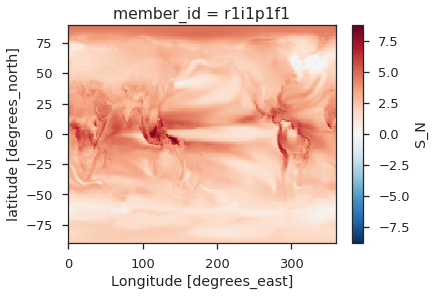

In [7]:
(sn_ds['S_N']
 .sel(year=slice(2030, 2050))
 .mean('year')
 .plot.imshow('lon', 'lat')
)

## Calculate ToE

So now we have a signal to noise ratio.  We are ready to estimate time of emergence.  We decide that <b> time of emergence </b> is the first year in which some signal-to-noise ratio exceeds a threshold that we set.  The easiest way to calculate the year of emergence is just to loop over the time index of the data and record whenever the values in each grid cell are larger than a given threshold.
We estimate this first year for each gridpoint, which provides an output array with dimensions of <code>[lon x lat]</code>.  The values in the ToE array will be in units of years. 

In [8]:
template = sn_ds['S'].isel(year=0).data
toe_s = np.zeros_like(template)

toe_das = []
ratios = 1, 2, 3
for ratio in ratios:
    toe_s = np.zeros_like(template)
    for year in sn_ds.year:
        _sn_year = sn_ds['S_N'].sel(year=year).data
        toe_s[(toe_s == 0) & (_sn_year > ratio)] = year
        
    # Mask out zeros
    toe_s = np.ma.masked_equal(toe_s, 0)
    toe_da = xr.DataArray(toe_s, 
                          dims=['lon', 'lat'], 
                          coords=[sn_ds.lon, sn_ds.lat])
    toe_das.append(toe_da)

toe_ds = xr.concat(toe_das, dim=pd.Index(ratios, name='ratio'))
toe_ds.name = 'TOE'
sn_ds['TOE'] = toe_ds

Finally, we can plot the time of emergence.

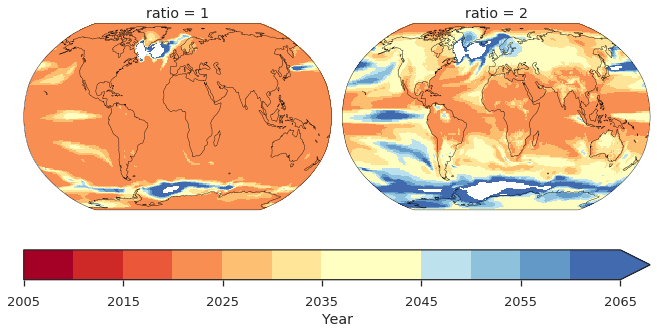

In [9]:
nrows, ncols = 1, 2
size, aspect = 4., 1.
width, height = size*aspect*ncols, size*nrows
figsize = (width, height)

g = sn_ds['TOE'].sel(ratio=[1, 2]).plot.imshow(
    x='lon', y='lat', col='ratio',
    vmin=2005, vmax=2065, extend='max', levels=13,
    cmap="RdYlBu",
    aspect=aspect, size=size,
    subplot_kws=dict(projection=ccrs.Robinson(),
                     aspect='auto'),
    cbar_kwargs=dict(orientation='horizontal',
                     label='Year'),
    transform=ccrs.PlateCarree()
)
for ax in g.axes.ravel():
    ax.coastlines()
    ax.set_aspect('auto', 'box')

And here we can save our time of emergence data.

In [12]:
sn_ds.to_netcdf(f'{variable_id}_{source_id}_{member_id}_sn_toe.nc')